#Notebook for testing performance of NLC classification
[Watson Developer Cloud](https://www.ibm.com/watsondevelopercloud) is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your solution. For more details on these various metrics, please consult the **[Is Your Chatbot Ready for Prime-Time?](https://developer.ibm.com/dwblog/2016/chatbot-cognitive-performance-metrics-accuracy-precision-recall-confusion-matrix/)** blog.


<br> The notebook assumes you have already created a Watson [Natural Language Classifier](https://www.ibm.com/watson/developercloud/nl-classifier.html) instance and trained a classifier. </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your NLC instance (username and password)
* id for your trained classifier (this is returned when you train an NLC classifier)
* csv file with your text utterances and corresponding class labels
* results csv file to write the results to

Note that the input test csv file should have a header with the fields **text** and **class**. 

In [1]:
#Import utilities
import json
import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas_ml
from pandas_ml import ConfusionMatrix
from watson_developer_cloud import NaturalLanguageClassifierV1

Provide the path to the parms file which includes credentials to access your NLC service as well as the input
test csv file and the output csv file to write the output results to.

In [2]:
# Provide complete path to the file which includes all required parms
# A sample parms file is included (example_parms.json)
nlcParmsFile = '/Users/kozhaya/Documents/MyFiles/CognitiveComputing/WATSON/EcoSystem/Partners/ForeSee/forseeretail_nlc_parms.json'
parms = ''
with open(nlcParmsFile) as parmFile:
    parms = json.load(parmFile)

url=parms['url']
user=parms['user']
password=parms['password']
nlc_id=parms['nlc_id']
test_csv_file=parms['test_csv_file']
results_csv_file=parms['results_csv_file']
confmatrix_csv_file=parms['confmatrix_csv_file']

json.dumps(parms)

# Create an object for your NLC instance
natural_language_classifier = NaturalLanguageClassifierV1(
  username=user,
  password=password)

Define useful methods to classify using trained NLC classifier.

In [3]:
# Given a text string and a pointer to NLC instance and classifierID, get back NLC response
def getNLCresponse(nlc_instance,classifierID,string):
    classes = nlc_instance.classify(classifierID, string)
    return classes

# Process multiple text utterances (provided via csv file) in batch. Effectively, read the csv file and for each text
# utterance, get NLC response. Aggregate and return results.
def batchNLC(nlc_instance,classifierID,csvfile):
    test_classes=[]
    nlcpredict_classes=[]
    nlcpredict_confidence=[]
    text=[]
    i=0
    with open(csvfile, 'rb') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            #print 'analyzing row: ', i, ' text: ', row['text']
            nlc_response = getNLCresponse(nlc_instance,classifierID,row['text'])
            nlcpredict_classes.append(nlc_response['classes'][0]['class_name'])
            nlcpredict_confidence.append(nlc_response['classes'][0]['confidence'])
            text.append(row['text'])
            i = i+1
            if(i%250 == 0):
                print "Processed ", i, " records"
        print "Finished processing ", i, " records"        
    return test_classes, nlcpredict_classes, nlcpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

In [4]:
# This is an optional step to quickly test response from NLC for a given utterance
#testQ='can I reset my password'
#results = getNLCresponse(natural_language_classifier,nlc_id,testQ)
#print(json.dumps(results, indent=2))

Call NLC on the specified csv file and collect results.

In [6]:
test_classes,nlcpredict_classes,nlcpredict_conf,text=batchNLC(natural_language_classifier,nlc_id,test_csv_file)

Processed  250  records
Processed  500  records
Processed  750  records
Processed  1000  records
Processed  1250  records
Processed  1500  records
Processed  1750  records
Processed  2000  records
Processed  2250  records
Processed  2500  records
Processed  2750  records
Processed  3000  records
Processed  3250  records
Processed  3500  records
Processed  3750  records
Processed  4000  records
Processed  4250  records
Finished processing  4444  records


In [7]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by NLC.
csvfileOut=results_csv_file
with open(csvfileOut, 'wb') as csvOut:
    outrow=['text','true class','NLC Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(text)):
        outrow=[text[i],test_classes[i],nlcpredict_classes[i],str(nlcpredict_conf[i])]
        csvWriter.writerow(outrow)

In [8]:
# Compute confusion matrix
labels=list(set(test_classes))
nlc_confusion_matrix = confusion_matrix(test_classes, nlcpredict_classes, labels)
nlcConfMatrix = ConfusionMatrix(test_classes, nlcpredict_classes)

In [9]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(nlc_confusion_matrix,labels,confmatrix_csv_file)

/Users/kozhaya/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


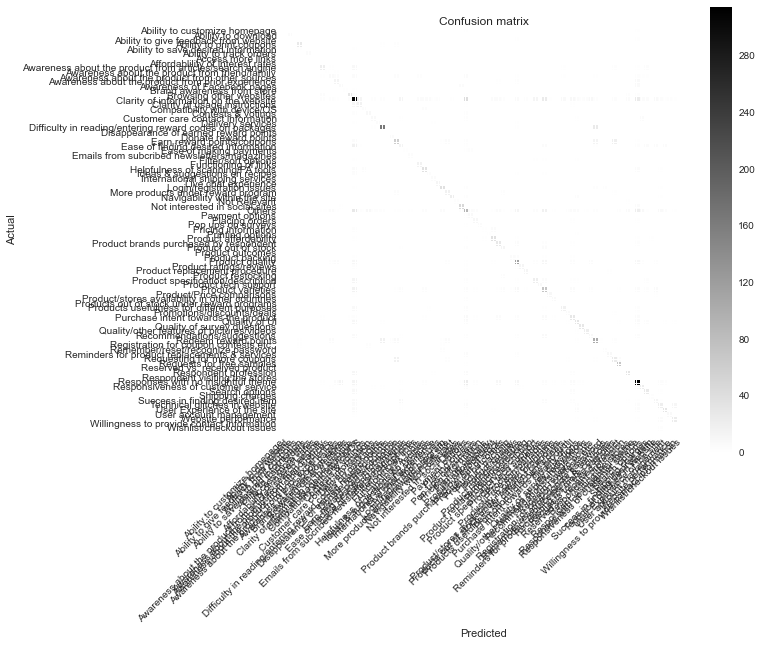

In [10]:
%matplotlib inline
nlcConfMatrix.plot()

In [11]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, nlcpredict_classes)
print 'Classification Accuracy: ', acc

Classification Accuracy:  0.50697569757


In [12]:
# print precision, recall and f1-scores for the different classes
print(classification_report(test_classes, nlcpredict_classes, labels=labels))

                                                         precision    recall  f1-score   support

                                    Ability to download       0.75      0.67      0.71         9
         Product/stores availability in other countries       0.38      0.53      0.44        15
                                Ability to track orders       0.83      0.56      0.67         9
                                Ease of making payments       0.33      0.20      0.25        10
                              Login/registration issues       0.65      0.67      0.66        58
                                     Product restocking       0.00      0.00      0.00         5
                         Ideas & suggestions on recipes       0.27      0.29      0.28        14
                 Product brands purchased by respondent       0.45      0.63      0.53        46
                                        Payment options       0.42      0.50      0.46        16
                             

/Users/kozhaya/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(test_classes, nlcpredict_classes, labels=labels)
#print "precision: ", precision
#print "recall: ", recall
#print "f1 score: ", fscore
#print "support: ", support